In [50]:
import torch, os, cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -q yolov5

In [56]:
import sys
sys.path.append('./yolov5')
from utils.general import non_max_suppression
from yolov5.utils.general import *
from yolov5.utils.datasets import *
from PIL import Image, ImageDraw

In [2]:
p = '../input/notebook6c10a791fd/runs/train/exp/weights/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'yolov5m6', classes=5, pretrained=False, autoshape=False)
ckpt = torch.load(p)
model.load_state_dict(ckpt['model'].state_dict())
model.names = ['ats', 'breaker', 'motor', 'spd', 'transformer']
model.nc = 5
model = model.autoshape()
model = model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


In [3]:
root = '../input/images-fs-to-tile'
fs = os.listdir(root)

In [4]:
img = cv2.imread(os.path.join(root, fs[0]))

In [5]:
sz = 1024
stride = 1024 - 128

def tiler(img):
    img = torch.from_numpy(img)
    if len(img.shape) == 2: img = torch.unsqueeze(img, -1)
    img = img.unfold(0, sz, stride).unfold(1, sz, stride)
    img = img.contiguous().view(img.shape[0] * img.shape[1], img.shape[2], sz, sz)
    return img

In [6]:
tiles = tiler(img)

In [31]:
def detect1Image(img, imgsz, model, device, conf_thres, iou_thres):

    img = torch.from_numpy(img).to(device)
    img =  img.float()  
    img /= 255.0   
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]

    pred = non_max_suppression(pred, conf_thres, iou_thres)

    boxes = []
    scores = []
    classes = []
    for i, det in enumerate(pred):
        if det is not None and len(det):
            for *xyxy, conf, cls in det:
                boxes.append([int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])])
                scores.append(conf)
                classes.append(cls)
    return np.array(boxes), np.array(scores), np.array(classes)

In [33]:
boxes, conf, classes = detect1Image(tiles[11].numpy(), 1024, model, 'cpu', 0.5, 0.6)

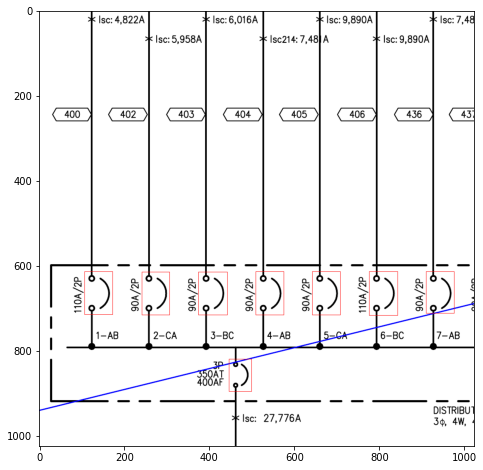

In [72]:
img = Image.fromarray(tiles[11].permute(1, 2, 0).numpy())
draw = ImageDraw.Draw(img)

for box in boxes:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline ="red")
    
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(img)